# National Oceanic and Atmospheric Administration (NOAA)
This jupyter notebook is meant to be used along with the North American Mesoscale Forecast System (NAM) dataset.  
This dataset can be found online under "Data Access > Model > Datasets > NAM" on the NOAA website.  
Once the data has been properly requested, confirmed, and processed using NOAA's Order Data feature,  
the requester is given 5 days to download the data via a email-link.  

# NAM 2017
To be more specific, the range this notebook will be targetting is the entire 2017 year (1800 UTC only). (100 ish Gb)  
Through further observation of the email-link provided by NOAA, it can be seen that the files end in an extension ".tar".  
These are all just zipped files. BEWARE- unpacking all these files doubles the 100Gb to 200Gb.  
It is recommended to make a main folder (moddata) with subfolders with each month on them (01, 02, 03, ..., 12).  
Then, putting all the corresponding ".tar" files in their respective month folder. The idea is to unpack an entire month and then delete the ".tar" files for that month. That way you don't have to unpack 100Gb to 200Gb and then try to delete 100Gb. It will be more like unpacking 6Gb to 12Gb then deleting the .tar files to regain space.

# Unpacking ".tar" Files
The ".tar" file names should look like the following:

namanl_218_2017010118.g2.tar

The format is very simple: namanl_218_yyyymmddhh.g2.tar  
Where yyyy = year, mm = month, dd = day, hh = hour (UTC)  
The above file would then be of 2017 January 1st 18 UTC

Since this data ranges accross the entire North America continent, 18 UTC was chosen. In New York, 18 UTC translates to 2 P.M. This makes any "real images" from the dataset appear more visually appealing since that part of the Earth will be facing towards the sun. This would be better than "real images" of NA taken at night. This also saves a lot of space. Imagine simply having 2 timestamps per day instead of 1, this would easily double the size of the data. NOAA allows 4 timestamps per day (0 UTC, 6 UTC, 12 UTC, and 18 UTC).  

Once you're inside the month directory containing all the ".tar" files for that month, simply use the following command to unpack:

// assuming path /moddata/01 being the path to all of january's ".tar" files type  
// and that you are currently inside the /01 directory, type the following into the kernel:  
for f in *.tar; do tar -xvf $f; done

This command should run for about 20 seconds and you should see all the files being unpacked individually.  
For every ".tar" file unpacked, there should be 5 ".grb2" files

// now type the following command to delete all of the ".tar" files in that directory:  
rm -r *.tar

This is done for all 12 months until every subdirectory of /moddata contains only ".grb2" files.  
The new file format should be:

nam_218_20170101_1800_000.grb2

nam_218_yyyymmdd_hhhh_band.grb2

# Congratulations!
Once all of the ".grb2" for every month are neatly organized in their own folder, the Exploritory Data Analysis can begin!  
These files can be viewed using a python package called "pygrib".

If you have anaconda installed, simply use:  
conda install -c conda-forge pygrib

That's about it for installations. Now let's dive into the code--

In [1]:
import pygrib # used to view ".grb2" files
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def print_grbs(filepath):
    """
    filepath: only 1 file path, not a list
    this function displays all the meta-data for the given filepath
    """
    grbs = pygrib.open(filepath)
    for grb in grbs:
        print(grb)
    grbs.close()

In [3]:
def get_paths(filepath, year = 0, month = 0, band = 0, everything = 0):
    """
    filepath: a string containing the file path to the directory containing all the .grb2 files
    year: specific year
    month: specific month
    band: specific band
    everything: if it is 1, then this function returns the entire list of filepaths available
    """
    if (everything != 0):
        years = [2017]
        months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        bands = [0, 1, 2, 3, 6]
        lst = []
        for month in months:
            for day in range(1, month_days[month - 1] + 1):
                for year in years:
                    for band in bands:
                        if (month < 10 and day < 10):
                            lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + "0" + str(day) + "_1800_00" + str(band) + ".grb2")
                        elif (month < 10 and day >= 10):
                            lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + str(day) + "_1800_00" + str(band) + ".grb2")
                        elif (month >= 10 and day < 10):
                            lst.append(filepath + "/nam_218_" + str(year) + str(month) + "0" + str(day) + "_1800_00" + str(band) + ".grb2")
                        else:
                            lst.append(filepath + "/nam_218_" + str(year) + str(month) + str(day) + "_1800_00" + str(band) + ".grb2")
        return lst
    else:
        month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        lst = []
        for day in range(1,month_days[month - 1] + 1):
            if (month < 10 and day < 10):
                lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + "0" + str(day) +"_1800_00" + str(band) + ".grb2")
            elif (month < 10 and day >= 10):
                lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + str(day) +"_1800_00" + str(band) + ".grb2")
            elif (month >= 10 and day < 10):
                lst.append(filepath + "/nam_218_" + str(year) + str(month) + "0" + str(day) +"_1800_00" + str(band) + ".grb2")
            else:
                lst.append(filepath + "/nam_218_" + str(year) + str(month) + str(day) +"_1800_00" + str(band) + ".grb2")
        return lst

# Some Useful Indexes
339: temperature at the surface (K)  
340: soil temperature between 0.0-0.1m (K)  
341: soil moisture content between 0.0-0.1m (proportion)  
342: soil liquid content between 0.0-0.1m (porportion)
343: soil temperature between 0.1-0.4m (K)  
344: soil moisture content between 0.1-0.4m (proportion)  
345: soil liquid content between 0.1-0.4m (porportion)  
346: soil temperature between 0.4-1m (K)  
347: soil moisture content between 0.4-1m (proportion)  
348: soil liquid content between 0.4-1m (porportion)  
349: soil temperature between 1-2m (K)  
350: soil moisture content between 1-2m (proportion)  
351: soil liquid content between 1-2m (porportion)  
352: soil temperature at 3m (K)  
355: plant surface water (kg^m-2)  
356: water equivilant of accumulated snow depth (kg^m-2)  
357: snow cover (%)  
358: snow depth (m)  
360: soil porosity (proportion)
361: temperature at 2m above ground (K)  
362: specific humidity at 2m above ground (kg kg^-1)  
363: dew point temperature at 2m above ground (K)  
364: relative humidity at 2m above ground (%)  
367: total precipitation (kg m^-2)
368: convective precipitation (kg m^-2)  
371: Categorical snow  
372: Categorical ice pellets  
373: Categorical freezing rain  
374: Categorical rain  
375: Surface roughness (m)  
378: Vegetation (%)  
379: Vegetation Type (Integer(0-13))  
380: Soil type  
388: Geopotential Height (gpm)  
436: Lightning  
437: Land-sea mask:(0 - 1)  
438: Sea-ice cover:(0 - 1)  
442: Total Cloud Cover (%)  

In [4]:
def get_data(filepath, index = 339, everything = 0):
    """
    if everything != 0 then filepath has to be a list of filepath's
        returns a list of array's of the data at the given index of all the given days
    if everything = 0 then filepath is a singular filepath
        returns an array of the data at the given index of that specific day
    """
    if (everything != 0):
        temp_soil = []
        for file in filepath:
            grbs = pygrib.open(file)
            temp_soil.append(grbs[index].values)
            grbs.close()
        return temp_soil
    else:
        grbs = pygrib.open(filepath)
        temp_soil = grbs[index].values
        grbs.close()
        return temp_soil

# A list of all the possible filepaths

In [5]:
filepath = "/media/sf_moddata/2017"
all_paths = get_paths(filepath, everything = 1)
print(all_paths[0]) # 2017 january 31 18 utc band 0
print(all_paths[-1]) # 2017 december 31 18 utc band 6
print(len(all_paths)) # 365 days * 5 bands per day = 1825

/media/sf_moddata/2017/nam_218_20170101_1800_000.grb2
/media/sf_moddata/2017/nam_218_20171231_1800_006.grb2
1825


# A list of all december file paths of band 0

In [6]:
dec_paths = get_paths(filepath, 2017, 12, 0)
print(dec_paths[0]) # december 1
print(dec_paths[-1]) # december 31
print(len(dec_paths)) # 31 days * 1 band per day = 31

/media/sf_moddata/2017/nam_218_20171201_1800_000.grb2
/media/sf_moddata/2017/nam_218_20171231_1800_000.grb2
31


# Getting the surface temperature of december 1st

In [46]:
dec_1_temp_surf = get_data(dec_paths[0], 339)
print(dec_1_temp_surf)

[[300.37924 300.17926 300.27927 ... 302.17926 301.87924 301.77927]
 [300.17926 300.37924 300.27927 ... 301.97925 301.87924 301.77927]
 [299.97925 300.07925 300.47925 ... 301.77927 302.07925 301.77927]
 ...
 [278.47925 278.57925 278.67926 ... 276.37924 276.67926 276.67926]
 [278.47925 278.57925 278.77927 ... 276.57925 276.67926 276.67926]
 [278.47925 278.37924 278.37924 ... 276.67926 276.77927 276.67926]]


# Getting the surface temperature of the entire month of december

In [47]:
dec_temp_surf = get_data(dec_paths, 339, everything = 1)
print(dec_temp_surf)

[array([[300.37924, 300.17926, 300.27927, ..., 302.17926, 301.87924,
        301.77927],
       [300.17926, 300.37924, 300.27927, ..., 301.97925, 301.87924,
        301.77927],
       [299.97925, 300.07925, 300.47925, ..., 301.77927, 302.07925,
        301.77927],
       ...,
       [278.47925, 278.57925, 278.67926, ..., 276.37924, 276.67926,
        276.67926],
       [278.47925, 278.57925, 278.77927, ..., 276.57925, 276.67926,
        276.67926],
       [278.47925, 278.37924, 278.37924, ..., 276.67926, 276.77927,
        276.67926]], dtype=float32), array([[300.11533, 300.11533, 300.11533, ..., 302.11533, 301.81534,
        301.81534],
       [300.01535, 300.21533, 300.11533, ..., 301.91534, 301.81534,
        301.81534],
       [299.81534, 299.91534, 300.31534, ..., 301.71533, 301.91534,
        301.81534],
       ...,
       [278.51535, 278.61533, 278.61533, ..., 276.51535, 276.81534,
        276.91534],
       [278.51535, 278.61533, 278.81534, ..., 276.81534, 276.91534,
        27

# Visualizing the data

317.67926


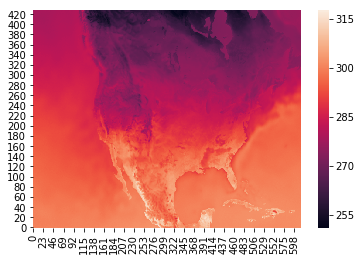

In [48]:
# lets try printing some of this data
rex = sns.heatmap(dec_1_temp_surf, cbar='true')
rex.invert_yaxis() # heatmap would print it upside down if it wasn't for this
print(np.max(dec_1_temp_surf))

# Grid Scaling for NAM
http://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID218

In [10]:
dec_1_temp_surf.shape

(428, 614)

# Latitude and Longitude
Let's discuss latitude first (the rows of the array's) [rows,cols] = (428, 614)  
row 0 is between 12.190N and 14.323N  
row 427 is between 54.564N and 57.328N  
The correct latitude crop needed is 31N to 41N  
so for the first and last row, lets take the middle degree.  
row 0 is now (12.190 + 14.323)/2 = 13.256N  
row 427 is now (54.564 + 57.328)/2 = 55.946N  
dividing the range of degrees by the number of rows, gives us the degree per row  
(55.946+13.256)/428 = 0.162 degrees per row  
x(0.100) = 31 => x = 31/0.100 = row 310
x(0.100) = 51 => x = 51/0.100 = row

In [63]:
#(12.190 + 14.323)/2
#(54.564 + 57.328)/2
(55.946+13.256)/2
#31/0.162

34.601

317.67926


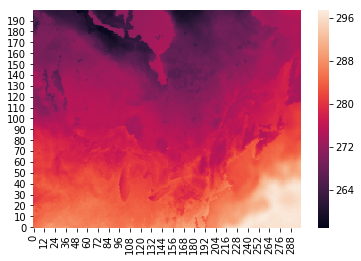

In [50]:
# lets try printing some of this data
dec_1_temp_surf_crop = dec_1_temp_surf[200:400,300:600]
dec_1_temp_surf_crop.shape
rex = sns.heatmap(dec_1_temp_surf_crop, cbar='true')
rex.invert_yaxis() # heatmap would print it upside down if it wasn't for this
print(np.max(dec_1_temp_surf))

In [22]:
print_grbs(dec_paths[0])

1:Pressure reduced to MSL:Pa (instant):lambert:meanSea:level 0:fcst time 0 hrs:from 201712011800
2:Derived radar reflectivity:dB (instant):lambert:hybrid:level 1:fcst time 0 hrs:from 201712011800
3:Maximum/Composite radar reflectivity:dB (instant):lambert:unknown:level 0 200:fcst time 0 hrs:from 201712011800
4:Visibility:m (instant):lambert:surface:level 0:fcst time 0 hrs:from 201712011800
5:Visibility:m (instant):lambert:cloudTop:level 0:fcst time 0 hrs:from 201712011800
6:Blackadar mixing length scale:m (instant):lambert:hybrid:level 1:fcst time 0 hrs:from 201712011800
7:Geopotential Height:gpm (instant):lambert:unknown:level 0 220:fcst time 0 hrs:from 201712011800
8:U component of wind:m s**-1 (instant):lambert:unknown:level 0 220:fcst time 0 hrs:from 201712011800
9:V component of wind:m s**-1 (instant):lambert:unknown:level 0 220:fcst time 0 hrs:from 201712011800
10:Ventilation Rate:m**2 s**-1 (instant):lambert:unknown:level 0 220:fcst time 0 hrs:from 201712011800
11:Wind speed (gu

121:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
122:Temperature:K (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
123:Relative humidity:% (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
124:Vertical velocity:Pa s**-1 (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
125:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
126:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
127:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
128:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 37500 Pa:fcst time 0 hrs:from 201712011800
129:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 40000 Pa:fcst time 0 hrs:from 201712011800


230:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 70000 Pa:fcst time 0 hrs:from 201712011800
231:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 70000 Pa:fcst time 0 hrs:from 201712011800
232:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 70000 Pa:fcst time 0 hrs:from 201712011800
233:Absolute vorticity:s**-1 (instant):lambert:isobaricInhPa:level 70000 Pa:fcst time 0 hrs:from 201712011800
234:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 70000 Pa:fcst time 0 hrs:from 201712011800
235:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 72500 Pa:fcst time 0 hrs:from 201712011800
236:Temperature:K (instant):lambert:isobaricInhPa:level 72500 Pa:fcst time 0 hrs:from 201712011800
237:Relative humidity:% (instant):lambert:isobaricInhPa:level 72500 Pa:fcst time 0 hrs:from 201712011800
238:Vertical velocity:Pa s**-1 (instant):lambert:isobaricInhPa:level 72500 Pa:fcst time 0 hrs:from 201712011800

304:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201712011800
305:U component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201712011800
306:V component of wind:m s**-1 (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201712011800
307:Turbulent kinetic energy:J kg**-1 (instant):lambert:isobaricInhPa:level 92500 Pa:fcst time 0 hrs:from 201712011800
308:Geopotential Height:gpm (instant):lambert:isobaricInhPa:level 95000 Pa:fcst time 0 hrs:from 201712011800
309:Temperature:K (instant):lambert:isobaricInhPa:level 95000 Pa:fcst time 0 hrs:from 201712011800
310:Relative humidity:% (instant):lambert:isobaricInhPa:level 95000 Pa:fcst time 0 hrs:from 201712011800
311:Vertical velocity:Pa s**-1 (instant):lambert:isobaricInhPa:level 95000 Pa:fcst time 0 hrs:from 201712011800
312:Geometric vertical velocity:m s**-1 (instant):lambert:isobaricInhPa:level 95000 Pa:fcst time 0 hrs:from 2

426:V component of wind:m s**-1 (instant):lambert:pressureFromGroundLayer:levels 15000-12000 Pa:fcst time 0 hrs:from 201712011800
427:Temperature:K (instant):lambert:pressureFromGroundLayer:levels 18000-15000 Pa:fcst time 0 hrs:from 201712011800
428:Relative humidity:% (instant):lambert:pressureFromGroundLayer:levels 18000-15000 Pa:fcst time 0 hrs:from 201712011800
429:U component of wind:m s**-1 (instant):lambert:pressureFromGroundLayer:levels 18000-15000 Pa:fcst time 0 hrs:from 201712011800
430:V component of wind:m s**-1 (instant):lambert:pressureFromGroundLayer:levels 18000-15000 Pa:fcst time 0 hrs:from 201712011800
431:Best (4-layer) lifted index:K (instant):lambert:pressureFromGroundLayer:levels 18000-0 Pa:fcst time 0 hrs:from 201712011800
432:Convective available potential energy:J kg**-1 (instant):lambert:pressureFromGroundLayer:levels 18000-0 Pa:fcst time 0 hrs:from 201712011800
433:Convective inhibition:J kg**-1 (instant):lambert:pressureFromGroundLayer:levels 18000-0 Pa:fcst

In [23]:
rex = pygrib.open(dec_paths[0]).

In [32]:
rex.close()

In [33]:
rex